# A short and sweet modification SBERT tutorial 

SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in the paper Sentence-BERT: [Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084).



In [1]:
# Install SentenceBert Library
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 2.0MB 11.3MB/s 
     |████████████████████████████████| 1.2MB 49.8MB/s 
     |████████████████████████████████| 870kB 44.4MB/s 
     |████████████████████████████████| 3.3MB 47.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=5b297f3760f171f967c4423f758994867f50f0b16bf0a50c8514db76b61d001e
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=fcaff2854432473c8dfff055848b28708f88b063d6c3ee3d172c806279d4435d
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sentence-transformers sacremoses


In [21]:
# Import kaggle dataset
import pandas as pd
pd.set_option('display.max_colwidth', 500)

df = pd.read_csv("/content/drive/MyDrive/Full Projects/Netflix Comp Search (Complete)/netflix_titles.csv")
df.head(), df.shape

(  show_id  ...                                                                                                                                            description
 0      s1  ...               In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.
 1      s2  ...   After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.
 2      s3  ...  When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp.
 3      s4  ...      In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group.
 4      s5  ...        A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack

In [6]:
# Filtering df
df = df[['title', 'rating', 'description']]

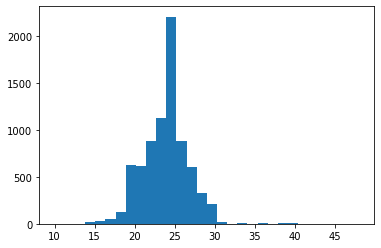

In [7]:
# Quick check of description lens (for BERT token len)
import matplotlib.pyplot as plt

lens = [len(x.split()) for x in df['description']]

plt.hist(lens, bins=30)
plt.show()

In [8]:
# Import library, utilities 
from sentence_transformers import SentenceTransformer, util
import torch

# Set embedding model and max_seq_len and push to GPU
embedder = SentenceTransformer('bert-base-uncased')
embedder.to('cuda')
# going a little longer for user inputed synopsis
embedder.max_seq_len = 128

Exception when trying to download http://sbert.net/models/bert-base-uncased.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/bert-base-uncased.zip not found. Try to create it from scratch
Try to create Transformer Model bert-base-uncased with mean pooling


In [9]:
# Set feature lists for concatonation to sematic asearch results
titles = df['title'].tolist()
ratings = df['rating'].tolist()
stories = df['description'].tolist()

# Fit model to corpus qnd push to GPU
story_embeddings = embedder.encode(stories, convert_to_tensor=True)
story_embeddings = story_embeddings.to('cuda')

# Just run the cell below and enter a title or a short synopsis which you would like to find similar results for. 

In [35]:
# Define Semantic Search Function
def semantic_search(input_data):
  # set lists to capture results
  title_list = []
  rating_list = []
  story_list = []
  score_list = []
  # empty dataframe to display results 
  results = pd.DataFrame()
  # Find the closest 5 stories of the corpus for each query sentence based on cosine similarity
  top_k = min(10, len(story_embeddings))
  

  if len(input_data) < 20 and input_data not in titles:
    print('Title Not Found')


  elif input_data in titles:
    query_embeddings = embedder.encode(str(df[df['title'] == input_data]['description'])[5:-33], convert_to_tensor=True)
    query_embeddings = query_embeddings.to('cuda')

    # Use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.pytorch_cos_sim(query_embeddings, story_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    input_data_2 = input_data.replace('.', '.\n')
    print("\n\n======================")
    print("\tSTORY")
    print("======================\n")
    print('',str(df[df['title'] == input_data]['description'])[5:-33])
    print("\n\n======================")
    print("    TOP 10 RESULTS")
    print("======================\n")
    
    # For score, index in torch.topk(cos_scores, k=top_k) use index  locator for feature lists
    # push score to cpu and convert to 1D array
    for score, idx in zip(top_results[0], top_results[1]):
      title_list.append(titles[idx])
      rating_list.append(ratings[idx])
      story_list.append(stories[idx])
      score_list.append(score.cpu().numpy().flatten())

    # Push results to dictionary columns 
    results['Title'] = title_list
    results['Rating'] = rating_list
    results['Story'] = story_list
    results['Score'] = score_list
    # return dictionary
    return results.iloc[1:, :]


  else:
    # Find the closest 5 stories of the corpus for each query sentence based on cosine similarity
    query_embeddings = embedder.encode(input_data, convert_to_tensor=True)
    query_embeddings = query_embeddings.to('cuda')

    # Use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.pytorch_cos_sim(query_embeddings, story_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    # input_data = input_data.replace(',', '.\n')
    print("\n\n======================")
    print("\tSTORY")
    print("======================\n")
    print(input_data[:105],"-")
    print(input_data[105:205],'-')
    print(input_data[205:])
    print("\n\n======================")
    print("    TOP 10 RESULTS")
    print("======================\n")
    
    # For score, index in torch.topk(cos_scores, k=top_k) use index  locator for feature lists
    # push score to cpu and convert to 1D array
    for score, idx in zip(top_results[0], top_results[1]):
      title_list.append(titles[idx])
      rating_list.append(ratings[idx])
      story_list.append(stories[idx])
      score_list.append(score.cpu().numpy().flatten())

    # Push results to dictionary columns 
    results['Title'] = title_list
    results['Rating'] = rating_list
    results['Story'] = story_list
    results['Score'] = score_list
    # return dictionary
    return results
      
  # User input function 
input_data = input("""Enter A Title or Short Story: """)
  # Push user input to Semantic Search function
semantic_search(str(input_data))

Enter A Title or Short Story: Chappie


	STORY

    In a futuristic society where a robot police force keeps crime at bay, a lone droid gains the power of artificial intelligence.


    TOP 10 RESULTS



,Title,Rating,Story,Score
1,Ad Vitam,TV-MA,"In a future where regeneration technology lets humans live indefinitely, a cop and a troubled young woman investigate a strange wave of youth suicides.",[0.8928245]
2,2307: Winter's Dream,TV-MA,"In the frozen tundra of a futuristic Arizona where humans have been forced underground, a soldier hunts the bioengineered leader of a rebellion.",[0.89205563]
3,Outside the Wire,R,"In the near future, a drone pilot sent into a war zone finds himself paired with a top-secret android officer on a mission to stop a nuclear attack.",[0.8870739]
4,Anon,TV-MA,"In a future where technology has rendered privacy obsolete, a detective investigates a serial assassin who has been deleted from all visual records.",[0.8847845]
5,9,PG-13,"In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group.",[0.8834822]
6,Robotech,TV-MA,"When a mysterious spaceship crashes in the Pacific, the people of Earth work to master the science of robotechnology and rebuild the giant fortress.",[0.8795343]
7,Incoming,TV-MA,"When an imprisoned terrorist cell hijacks a high-security prison in outer space, a CIA agent becomes the one chance of stopping them.",[0.87654227]
8,Automata,R,"In a dystopian future, an insurance adjuster for a tech company investigates a robot killed for violating protocol and discovers a global conspiracy.",[0.8749506]
9,Cleverman,TV-MA,"In the near future, physically powerful beings known as ""Hairies"" struggle to survive in a segregated society dominated by hostile humans.",[0.87423056]
